In [1]:
# boilerplate sanity check
import os,warnings,cpuinfo,multiprocessing,psutil,sys
warnings.simplefilter(action='ignore',category=FutureWarning)
try:cpu=cpuinfo.get_cpu_info();print('CPU says hello!\n-name: {}\n-architecture: {}\n-bits: {}\n-frequency: {}\n-threads: {}\n-l3_cache: {}\n-l2_cache: {}\n-l1_cache: {}'.format(cpu['brand'],cpu['arch'],cpu['bits'],cpu['hz_actual'],multiprocessing.cpu_count(),cpu['l3_cache_size'],cpu['l2_cache_size'],cpu['l1_data_cache_size']))
except:print('Failed to get all CPU info!')
try:print('RAM says hello!\n-virtual: {} GB\n-swap: {} GB'.format(round(psutil.virtual_memory().total/1024**3,2),round(psutil.swap_memory().total/1024**3,2)))
except:print('Failed to get all RAM info!')
print('Python says hello!\n-python: {}'.format(sys.version.split(' ')[0]))

CPU says hello!
-name: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
-architecture: X86_64
-bits: 64
-frequency: 3.4784 GHz
-threads: 8
-l3_cache: 6144 KB
-l2_cache: 1 MiB
-l1_cache: 128 KiB
RAM says hello!
-virtual: 30.93 GB
-swap: 0.95 GB
Python says hello!
-python: 3.9.19


In [2]:
import os
import re
import gc
import sys
import math
import numpy as np
import cv2 as cv2
import scipy.ndimage as ndimage
import nibabel as nib
import matplotlib.pyplot as plt
import multiprocessing
import psutil
import time

np.seterr(over='ignore',under='ignore')

def poolWrapper(f, d):
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        res = pool.map(f, d)
    return res

In [3]:
def readData(name, mask=True):
    #dMRI data
    diffusion      = nib.load('data/'+name+'/Diffusion/data.nii.gz')
    #brain mask for dMRI
    diffusion_mask = nib.load('data/'+name+'/Diffusion/nodif_brain_mask.nii.gz').get_fdata()
    #T1 MRI data
    t1             = nib.load('data/Registration_'+name+'/T1_restore_biascorr10/T1_restore.nii.gz')
    #brain mask for T1 MRI
    t1_mask        = nib.load('data/Registration_'+name+'/brain_mask.nii.gz').get_fdata()
    #ROI aka Basal Ganglia
    roi            = np.concatenate((
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Basal_G_Left/Striatum_diff_bin.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Basal_G_Right/Striatum_diff_bin.nii.gz').get_fdata(),-1),
                     ), axis=3)
    #cortical targets [Limbic,Executive,Rostral-Motor,Caudal-Motor,Parietal,Occipital,Temporal]
    targets        = np.concatenate((
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Limbic_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Executive_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Rostral_Motor_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Caudal_Motor_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Parietal_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Occipital_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Temporal_Left_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Limbic_Right_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Executive_Right_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Rostral_Motor_Right_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Caudal_Motor_Right_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Parietal_Right_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Occipital_Right_diff.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/ROIS/Temporal_Right_diff.nii.gz').get_fdata(),-1),
                     ), axis=3)
    #relative connectivity [Limbic,Executive,Rostral-Motor,Caudal-Motor,Parietal,Occipital,Temporal]
    connectivity   = np.concatenate((
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/L_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/E_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/RM_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/CM_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/P_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/O_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Left/T_relative_connectivity_Left.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/L_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/E_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/RM_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/CM_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/P_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/O_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                         np.expand_dims(nib.load('data/'+name+'/Classification_Right/T_relative_connectivity_Right.nii.gz').get_fdata(),-1),
                     ), axis=3)
    #get transformation matrices into anatomical space
    mat1 = diffusion.get_sform()
    mat2 = t1.get_sform()
    diffusion = diffusion.get_fdata()
    t1        = t1.get_fdata()
    #apply brain masks
    if mask:
        diffusion    = diffusion    * np.repeat(np.expand_dims(diffusion_mask,-1),diffusion.shape[-1],-1)
        t1           = t1           * t1_mask
        roi          = roi          * np.repeat(np.expand_dims(diffusion_mask,-1),roi.shape[-1],-1)
        targets      = targets      * np.repeat(np.expand_dims(diffusion_mask,-1),targets.shape[-1],-1)
        connectivity = connectivity * np.repeat(np.expand_dims(diffusion_mask,-1),connectivity.shape[-1],-1)
    #apply correct data types
    diffusion      = np.array(diffusion     ,dtype=np.float16)
    t1             = np.array(t1            ,dtype=np.float16)
    roi            = np.array(roi           ,dtype=np.bool_  )
    targets        = np.array(targets       ,dtype=np.bool_  )
    connectivity   = np.array(connectivity  ,dtype=np.float16)
    diffusion_mask = np.array(diffusion_mask,dtype=np.bool_  )
    t1_mask        = np.array(t1_mask       ,dtype=np.bool_  )
    return [[diffusion, t1, roi, targets, connectivity, diffusion_mask, t1_mask], [mat1, mat2]]

def readDataMulti(names, mask=True):
    datas = []
    mats = []
    for name in names:
        data, mat = readData(name, mask=mask)
        if len(datas)==0:
            for _ in range(len(data)): datas.append([])
            for _ in range(len(mat)): mats.append([])
        for i in range(len(data)):
            datas[i].append(data[i])
        for i in range(len(mat)):
            mats[i].append(mat[i])
    return [datas, mats]

def getBounds(dim, mat):
    #corners
    cor = np.zeros((8,4))
    cor[:,3] = 1
    cor[1,0:3] = dim[0:3]
    cor[2,0:2] = dim[0:2]
    cor[3,1:3] = dim[1:3]
    cor[4,[0,2]] = dim[[0,2]]
    cor[5,0] = dim[0]
    cor[6,1] = dim[1]
    cor[7,2] = dim[2]
    #calcualte transformed coordinates for every corner
    res = np.array([np.dot(mat,x)[0:3] for x in cor])
    #return min-max values
    return np.append(np.expand_dims(np.min(res,0),0),np.expand_dims(np.max(res,0),0),0)

def affineTransformWrapper(inp):
    data, mat, output_shape, order = inp
    if data.dtype == np.float16:
        data = np.array(data,dtype=np.float32)
    return ndimage.affine_transform(data,mat,output_shape=output_shape,order=order)

def toSpace(data, mat, space=None, order=0):
    #add dim if not present
    if len(data.shape) == 3:
        data = np.expand_dims(data,-1)
    #get shape of voxel space
    shape = np.array(data.shape)
    #calculate bounds of transformed voxel space (aka world space)
    bounds = getBounds(shape,mat)
    #calculate new shape of world space
    new_shape = np.array(bounds[1]-bounds[0],dtype=np.int32)
    #calculate translation value if not provided
    if space is None:
        space = np.identity(4)
        space[0:3,3] = -1*bounds[0]
    #add translation
    mat = np.dot(space,mat)
    #transfom voxel space
    mat = np.linalg.inv(mat)
    #split work for multithreading
    splitted = []
    for i in range(shape[3]):
        splitted.append([data[:,:,:,i],mat,new_shape,order])
    #process it multithreaded
    transformed = np.array(poolWrapper(affineTransformWrapper,splitted))
    transformed = np.transpose(transformed,[1,2,3,0])
    #return world space and used translation
    return (transformed, space)

def cropToSmallest(data):
    #get minimum of each dim from all datas
    shape = np.min(np.array([d.shape for d in data]),0)
    #crop to smallest for each dim
    return [d[0:shape[0],0:shape[1],0:shape[2],:] for d in data]

def normalizeData(data, mat):
    #unpack data
    diffusion, t1, roi, targets, connectivity, diffusion_mask, t1_mask = data
    #convert all data to same anatomical space
    diffusion,      space = toSpace(diffusion      , mat[0], None )
    diffusion             = np.array(diffusion     ,dtype=np.float16)
    t1            , _     = toSpace(t1             , mat[1], space)
    t1                    = np.array(t1            ,dtype=np.float16)
    roi           , _     = toSpace(roi            , mat[0], space)
    roi                   = np.array(roi           ,dtype=np.bool_  )
    targets       , _     = toSpace(targets        , mat[0], space)
    targets               = np.array(targets       ,dtype=np.bool_  )
    connectivity  , _     = toSpace(connectivity   , mat[0], space)
    connectivity          = np.array(connectivity  ,dtype=np.float16)
    diffusion_mask, _     = toSpace(diffusion_mask , mat[0], space)
    diffusion_mask        = np.array(diffusion_mask,dtype=np.bool_  )
    t1_mask       , _     = toSpace(t1_mask        , mat[1], space)
    t1_mask               = np.array(t1_mask       ,dtype=np.bool_  )
    #return cropped tensors
    return cropToSmallest([diffusion, t1, roi, targets, connectivity, diffusion_mask, t1_mask])

def normalizeDataMulti(datas, mats, free_memory=False):
    norms = []
    for _ in range(len(datas)):
        norms.append([])
    #datapoint idx (loop for datapoints)
    for i in range(len(datas[0])):
        n = normalizeData([datas[j][i] for j in range(len(datas))],[mats[j][i] for j in range(len(mats))])
        #drop references continously
        if free_memory:
            for j in range(len(datas)): datas[j][i] = None
            for j in range(len(mats)): mats[j][i] = None
            gc.collect()
        for j in range(len(n)):
            norms[j].append(n[j])
    return norms

def findMaskBounds(mask, axis):
    # mask columns which are only consisted of zeros
    mask_zero_columns = np.where(np.sum(mask, axis=axis) == 0, sys.maxsize, 0)
    #get lower bound along axis
    lower_bound =                    np.min(np.argmax(mask, axis=axis)                     + mask_zero_columns)
    #get upper bound along axis
    upper_bound = mask.shape[axis] - np.min(np.argmax(np.flip(mask, axis=axis), axis=axis) + mask_zero_columns)
    #return bounds
    return [lower_bound, upper_bound]

def cropDataToMasks(datas, free_memory=False):
    bounds = []
    ranges = []
    #datapoint idx (loop for datapoints)
    for i in range(len(datas[0])):
        b = []
        r = []
        #calculate bounds and range for each axis
        for axis in range(3):
            #get both diffusion and t1 mask bounds
            diffusion_bounds = findMaskBounds(datas[5][i], axis)
            t1_bounds        = findMaskBounds(datas[6][i], axis)
            #combine the two bounds
            b.append([min(diffusion_bounds[0],t1_bounds[0]),max(diffusion_bounds[1],t1_bounds[1])])
            #calculate range from bounds
            r.append(b[-1][1]-b[-1][0])
        bounds.append(b)
        ranges.append(r)
    bounds = np.array(bounds)
    ranges = np.array(ranges)
    #select maximum for each axis to get a new shape that fits all brains
    new_shape = np.max(ranges,axis=0)
    uniforms = []
    #data array idx (loop for data arrays)
    for i in range(len(datas)):
        #get shape of singular datapoint from selected data array
        s = np.array(datas[i][-1].shape)
        #convert the datapoint shape's first 3 dimensions to new dim
        s[0:3] = new_shape
        uniform = []
        #datapoint idx (loop for datapoints)
        for j in range(len(datas[0])):
            #get the shape difference's half between the old and new shapes
            shape_diff_half = np.array((new_shape-ranges[j])//2,dtype=np.int32)
            #create a new array with the new size
            d = np.zeros(s,dtype=datas[i][-1].dtype)
            #fill array with the cropped out brain, centered (shifted) with the shape diffrence's half
            d[shape_diff_half[0]:shape_diff_half[0]+ranges[j,0],
              shape_diff_half[1]:shape_diff_half[1]+ranges[j,1],
              shape_diff_half[2]:shape_diff_half[2]+ranges[j,2],:] = datas[i][j][bounds[j,0,0]:bounds[j,0,1],
                                                                                 bounds[j,1,0]:bounds[j,1,1],
                                                                                 bounds[j,2,0]:bounds[j,2,1],:]
            #drop references continously
            if free_memory:
                datas[i][j] = None
            uniform.append(d)
        uniforms.append(np.array(uniform))
    return uniforms

In [4]:
def centerSlices(data, data2=None, blend=0.5, slices=None):
    #slice off first dim if multiple datapoints are passed
    if len(data.shape) == 5:
        data = data[0,:,:,:,:]
    #slice off last dimension
    if len(data.shape) == 4:
        data = data[:,:,:,0]
    #if exact XYZ slices are not defined, get the center from XY and 2/3 from Z
    if slices is None:
        slices = [data.shape[0]//2,data.shape[1]//2,2*data.shape[2]//3]
    #display slices
    if data2 is None:
        plt.imshow(data[slices[0],:,:])
        plt.show()
        plt.imshow(data[:,slices[1],:])
        plt.show()
        plt.imshow(data[:,:,slices[2]])
        plt.show()
    #display overlayed slices
    else:
        #slice off first dim if multiple datapoints are passed
        if len(data2.shape) == 5:
            data2 = data2[0,:,:,:,:]
        #slice off last dimension
        if len(data2.shape) == 4:
            data2 = data2[:,:,:,0]
        #fix opencv datatype requirement
        if data.dtype == np.float16:
            data = np.array(data, dtype=np.float32)
        if data2.dtype == np.float16:
            data2 = np.array(data2, dtype=np.float32)
        #show blend of two images
        plt.imshow(cv2.addWeighted(data[slices[0],:,:], blend, data2[slices[0],:,:], 1-blend, 0))
        plt.show()
        plt.imshow(cv2.addWeighted(data[:,slices[1],:], blend, data2[:,slices[1],:], 1-blend, 0))
        plt.show()
        plt.imshow(cv2.addWeighted(data[:,:,slices[2]], blend, data2[:,:,slices[2]], 1-blend, 0))
        plt.show()

#TODO: rework this spaghetti code
def printProperties(data, multi=True, uniform=False):
    if multi and not uniform:
        original = data
        data = [d[0] for d in data]
    for i in range(len(data)):
        d = data[i]
        try:
            if multi and not uniform:
                print('('+str(len(original[i]))+') '+str(d.shape)+'0th')
            else:
                print(d.shape)
            print(d.dtype)
        except:
            d = d.get_fdata()
            print(d.dtype)
        d0 = d
        if multi and uniform:
            d = d[0,:,:,:,:]
        while np.prod(np.array(d.shape)) > 100000000:
            t = d
            for i in range(len(d.shape)):
                t = t.take(indices=range(0,d.shape[i]//2),axis=i)
            d = t
        u,c = np.unique(d,return_counts=True)
        cnt = dict(zip(u,c))
        if (len(cnt) > 100):
            print('MANY! '+str(np.min(d0))+'-'+str(np.max(d0)))
        else:
            print(cnt)

In [5]:
names = os.listdir('data')
r = re.compile('[CH]\d.*')
names = [s for s in names if r.match(s)]

tmp = time.time()
raws, mats = readDataMulti(names)
print('Records: {}\nRAM:     {}GB\nTime:    {}s\n================='.format(len(names),round(psutil.Process().memory_info().rss/1024**3,1),round(time.time()-tmp)))
printProperties(raws, multi=True, uniform=False)

Records: 1
RAM:     0.3GB
Time:    3s
(1) (118, 118, 60, 74)0th
float16


MANY! 0.0-2492.0
(1) (208, 256, 256)0th
float16


MANY! 0.0-629.0
(1) (118, 118, 60, 2)0th
bool
{False: 1666954, True: 3926}
(1) (118, 118, 60, 14)0th
bool
{False: 11611355, True: 84805}
(1) (118, 118, 60, 14)0th
float16


MANY! 0.0-1.0
(1) (118, 118, 60)0th
bool
{False: 586405, True: 249035}
(1) (208, 256, 256)0th
bool


{False: 12037217, True: 1594271}


In [6]:
tmp = time.time()
normalizeds = normalizeDataMulti(raws, mats, free_memory=True)
print('Records: {}\nRAM:     {}GB\nTime:    {}s\n================='.format(len(names),round(psutil.Process().memory_info().rss/1024**3,1),round(time.time()-tmp)))
printProperties(normalizeds, multi=True, uniform=False)

Records: 1
RAM:     1.8GB
Time:    20s
(1) (220, 240, 129, 74)0th
float16


MANY! 0.0-2492.0
(1) (220, 240, 129, 1)0th
float16


MANY! 0.0-629.0
(1) (220, 240, 129, 2)0th
bool
{False: 13590988, True: 31412}
(1) (220, 240, 129, 14)0th
bool


{False: 94679331, True: 677469}
(1) (220, 240, 129, 14)0th
float16


MANY! 0.0-1.0
(1) (220, 240, 129, 1)0th
bool
{False: 4835370, True: 1975830}
(1) (220, 240, 129, 1)0th
bool
{False: 5272904, True: 1538296}


In [7]:
tmp = time.time()
croppeds = cropDataToMasks(normalizeds, free_memory=True)
print('Records: {}\nRAM:     {}GB\nTime:    {}s\n================='.format(len(names),round(psutil.Process().memory_info().rss/1024**3,1),round(time.time()-tmp)))
printProperties(croppeds, multi=True, uniform=True)

Records: 1
RAM:     1.1GB
Time:    1s
(1, 150, 186, 124, 74)
float16


MANY! 0.0-2492.0
(1, 150, 186, 124, 1)
float16


MANY! 0.0-629.0
(1, 150, 186, 124, 2)
bool
{False: 6887788, True: 31412}
(1, 150, 186, 124, 14)
bool


{False: 47756931, True: 677469}
(1, 150, 186, 124, 14)
float16


MANY! 0.0-1.0
(1, 150, 186, 124, 1)
bool
{False: 1483770, True: 1975830}
(1, 150, 186, 124, 1)
bool
{False: 1921304, True: 1538296}


In [8]:
fnames = ['diffusion', 't1', 'roi', 'targets', 'connectivity', 'diffusion_mask', 't1_mask']
for i in range(len(fnames)):
    np.save('data/preprocessed/'+fnames[i], croppeds[i])

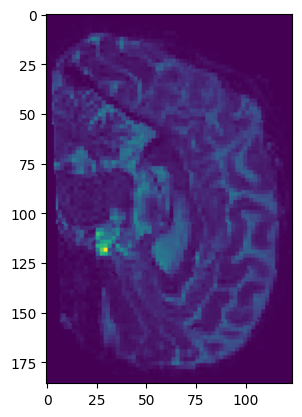

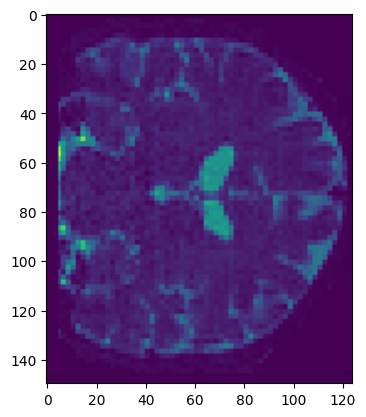

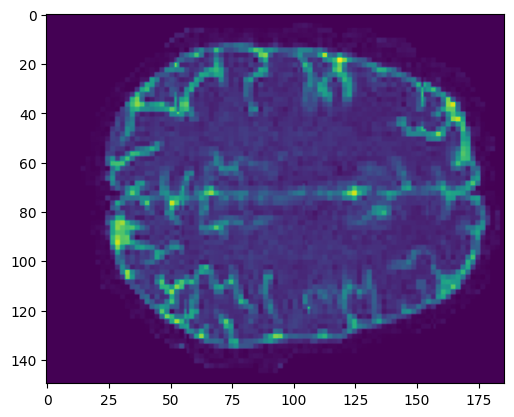

In [9]:
centerSlices(croppeds[0])

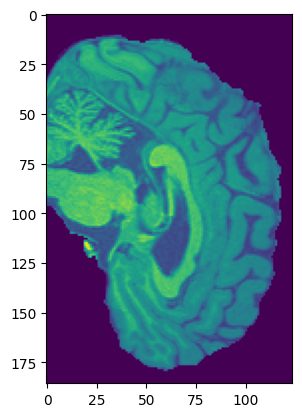

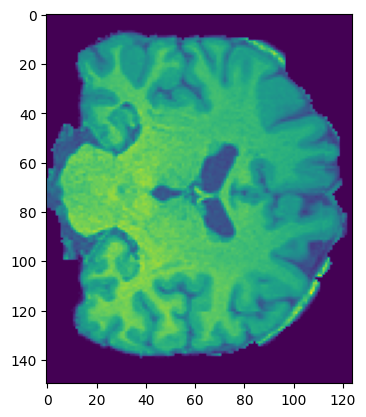

In [10]:
centerSlices(croppeds[1])

In [0]:
centerSlices(croppeds[0],croppeds[1],blend=0.3)